In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
    return np.abs(x)

In [3]:
def g(x, xk, alpha):
    return f(x) + (1 / (2 * alpha)) * (x - xk)**2

In [4]:
def subgradient_f(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0  # any value in [-1, 1]

def gradient_smooth_part(x, xk, alpha): #gradient of the convex part
    return (1 / alpha) * (x - xk)

In [5]:

#Compute the proximal operator for f(x) = |x|; This is the soft thresholding operator; as seen in the course
def proximal_gradient_step(xk, alpha):
    return np.sign(xk) * max(np.abs(xk) - alpha, 0)
    
def proximal_gradient_descent(x0, alpha, max_iter=100, tol=1e-6):
   
    x = x0
    trajectory = [x0]
    
    for i in range(max_iter):
        x_prev = x
        
        # gradient step on the smooth part
        grad_step = x - alpha * gradient_smooth_part(x, x, alpha)
        
        # prox step
        x = proximal_gradient_step(grad_step, alpha)
        
        # history
        trajectory.append(x)
        
        if np.abs(x - x_prev) < tol:
            break
    
    return x, trajectory

Z min: 0.002501250625312146, Z max: 505.0, Z mean: 85.91795897948974


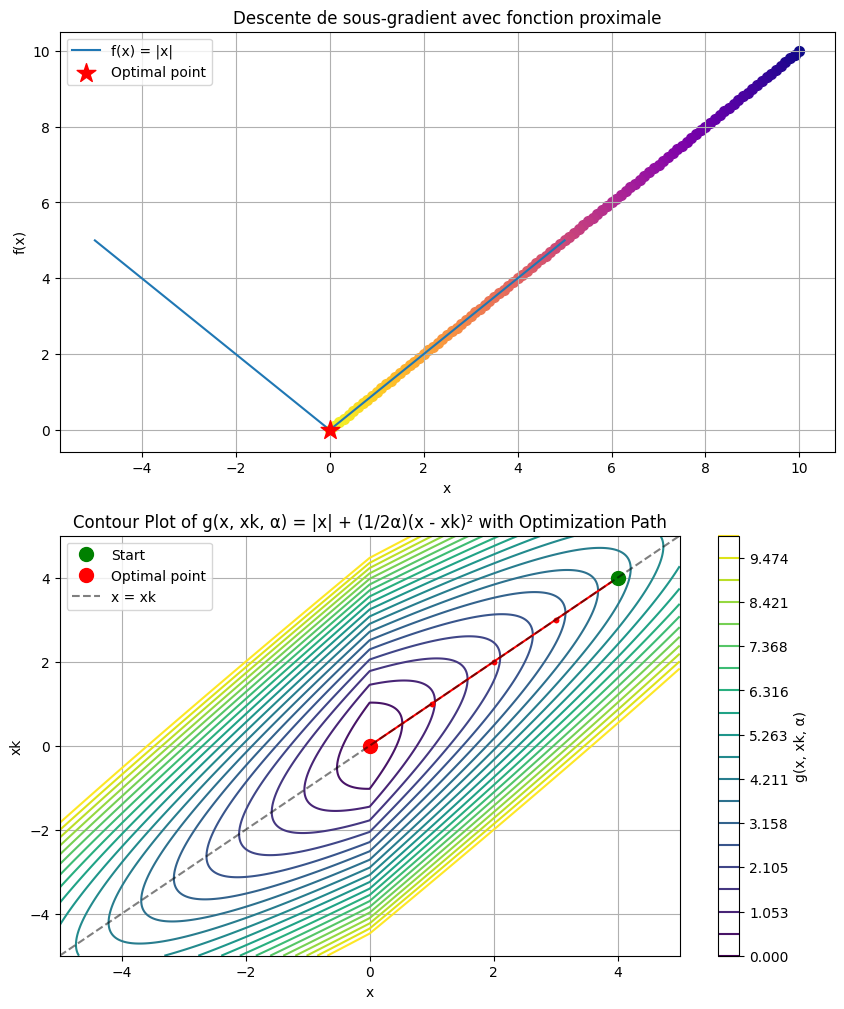

In [9]:
def plot_optimization_results(x0, alpha, num_iterations):
    final_x, trajectory = proximal_gradient_descent(x0, alpha, num_iterations)
    trajectory = np.array(trajectory)
    x = np.linspace(-5, 5, 2000)
    xk = np.linspace(-5, 5, 2000)
    X, XK = np.meshgrid(x, xk)

    Z = g(X, XK, alpha)

    print(f"Z min: {np.min(Z)}, Z max: {np.max(Z)}, Z mean: {np.mean(Z)}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    colors = plt.cm.plasma(np.linspace(0, 1, len(trajectory)))
    # Plot 1: Function and trajectory
    x_values = np.linspace(-5, 5, 400)
    y_values = f(x_values)

    ax1.plot(x_values, y_values, label="f(x) = |x|")

    # Plot trajectory with color gradient
    for i in range(len(trajectory) - 1):
        ax1.scatter(trajectory[i], f(trajectory[i]), color=colors[i], s=50)
        # Add arrows between points
        ax1.arrow(
            trajectory[i],
            f(trajectory[i]),
            trajectory[i + 1] - trajectory[i],
            f(trajectory[i + 1]) - f(trajectory[i]),
            head_width=0.1,
            head_length=0.1,
            fc=colors[i],
            ec=colors[i],
            alpha=0.5,
        )

    # Plot optimal point as star
    ax1.scatter(
        trajectory[-1],
        f(trajectory[-1]),
        marker="*",
        s=200,
        color="red",
        label="Optimal point",
        zorder=5,
    )

    ax1.set_xlabel("x")
    ax1.set_ylabel("f(x)")
    ax1.set_title("Descente de sous-gradient avec fonction proximale")
    ax1.legend()
    ax1.grid(True)

    
    alpha = 1.0
    Z = g(X, XK, alpha)
    
    x0 = 4.0 
    final_x, trajectory = proximal_gradient_descent(x0, alpha)
    trajectory = np.array(trajectory)
    
    levels = np.linspace(0, 10, 20)
    contours = plt.contour(X, XK, Z, levels=levels, cmap='viridis')
    plt.colorbar(contours, label='g(x, xk, α)')
    

    trajectory_points = list(zip(trajectory[:-1], trajectory[1:]))
    for (x1, x2) in trajectory_points:
        plt.plot([x1, x2], [x1, x2], 'r.-', linewidth=1.5)
    
    plt.plot(x0, x0, 'go', label='Start', markersize=10)
    plt.plot(final_x, final_x, 'ro', label='Optimal point', markersize=10)
    
    plt.xlabel('x')
    plt.ylabel('xk')
    plt.title('Contour Plot of g(x, xk, α) = |x| + (1/2α)(x - xk)² with Optimization Path')
    
    plt.plot([-5, 5], [-5, 5], 'k--', label='x = xk', alpha=0.5)
    
    plt.legend()
    plt.grid(True)
    plt.show()


x0 = 10.0
alpha = 0.1
num_iterations = 200
plot_optimization_results(x0, alpha, num_iterations)
